Introduction
---
In this section I wanted to do some analysis on tweets that I live scraped using Twitter's API. I left the program running for quite a few hours and put a file size cap on it to ensure that the file didn't get too large and crash my laptop. I saved these tweets in a json file, and then read it into notebook to begin analysing it. I focussed on Facebook here primarily because people tweeted about Facebook more frequently than other stocks and I managed to get a big training set in a small amount of time.  

The purpose was to begin analysing tweets and see if I can sort the 'useless' tweets from the tweets that actually told me something. I plan to do a lot more work in this area, and so here I am just starting with basic text similiarity. 

The idea is I will be able to create an algorithm that will be trained on a load of tweets and then be able to categorise new tweets without me having to go through the same process again. Using the filtered 'useful' tweets, I can then transfer that information to my stock market web. 

In [84]:
import tweepy
from tweepy import OAuthHandler, Stream
from tweepy.streaming import StreamListener
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import metrics, cluster
from sklearn.metrics import pairwise_distances
from sklearn.naive_bayes import MultinomialNB
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
import re
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from scipy.cluster.vq import kmeans, vq
from sklearn.preprocessing import scale
from pylab import plot, show
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline

Twitter Scraping
---
Using the useful API that Twitter has, I scraped a load of tweets in real time and filtered then using the cashtag of Facebook ($FB).

In [2]:
access_token = "345900832-uC52w9WBTJpIddmTrALCkf5iCNZKxChgHpnFbiok"
access_secret = "OuLf6anDEVnPoZYbTBNwcE2c8N8dQFdzUETB1ubNKMp1K"
consumer_key = "scvjvx5cBMDUolsahmfncM0Ev"
consumer_secret = "7xOTqvnGAKqu8dHefORHVo0sUfOkOjEQFko56Nux5l8SRAfORF"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

class MyListener(StreamListener):

    def on_data(self, data):
        try:
            with open('facebook_tweets1.json', 'a') as f:
                while os.path.getsize('facebook_tweets1.json') / float(1000000) < 200: 
                    f.write(data)

                    return True
        except BaseException as e:
            print "Error on_data:{}".format(str(e))
        return True

    def on_error(self, status):
        print(status)
        return True

twitter_stream = Stream(auth, MyListener())
twitter_stream.filter(track=['$FB'])

Basic Text Similiarity and the corresponding PCA map
--
I started with some basic NLP at the beginning, and directly compared tweets based on the words that were appearing in them using tf-idf technique (term frequency-inverse document frequency). Naturally this isn't going to produce great results because of the size of my tweets. It works by assigning weights based on the frequency of words and then inversing the weights, so that the words with lower weights get bumped up. This is get rid of the effect of words like 'the' and 'a' getting a heavy weight. 
This technique workds better on longer paragraphs. 

In [60]:
tweet_pd = pd.DataFrame()
with open('facebook_tweets1.json', 'r') as f:
    tweet_deats = [json.loads(line) for line in f]

In [61]:
tweets = [tweet_deats[i].get('text') for i in range(len(tweet_deats))]

In [62]:
str_tweets = []

In [63]:
for twee in tweets:
    split_tweet = []
    for twe in twee.split():
        try:
            split_tweet.append(str(twe))
        except:
            pass
    str_tweets.append(str(' '.join(split_tweet)).lower())

In [64]:
tweet_df = pd.DataFrame(str_tweets, columns=['Tweets'])

In [65]:
tfidf = TfidfVectorizer().fit_transform(str_tweets)

In [66]:
pairwise_similarity = (tfidf * tfidf.T).A

In [67]:
similarity_df = pd.DataFrame()
for i in range(len(str_tweets)):
    similarity_df['{}'.format(i)] = [corr for corr in pairwise_similarity[i]]

In [68]:
data = similarity_df.values
pca = PCA(n_components=len(similarity_df))
data_r = pca.fit(data).transform(data)
labels = [x for x in similarity_df.head(0)]

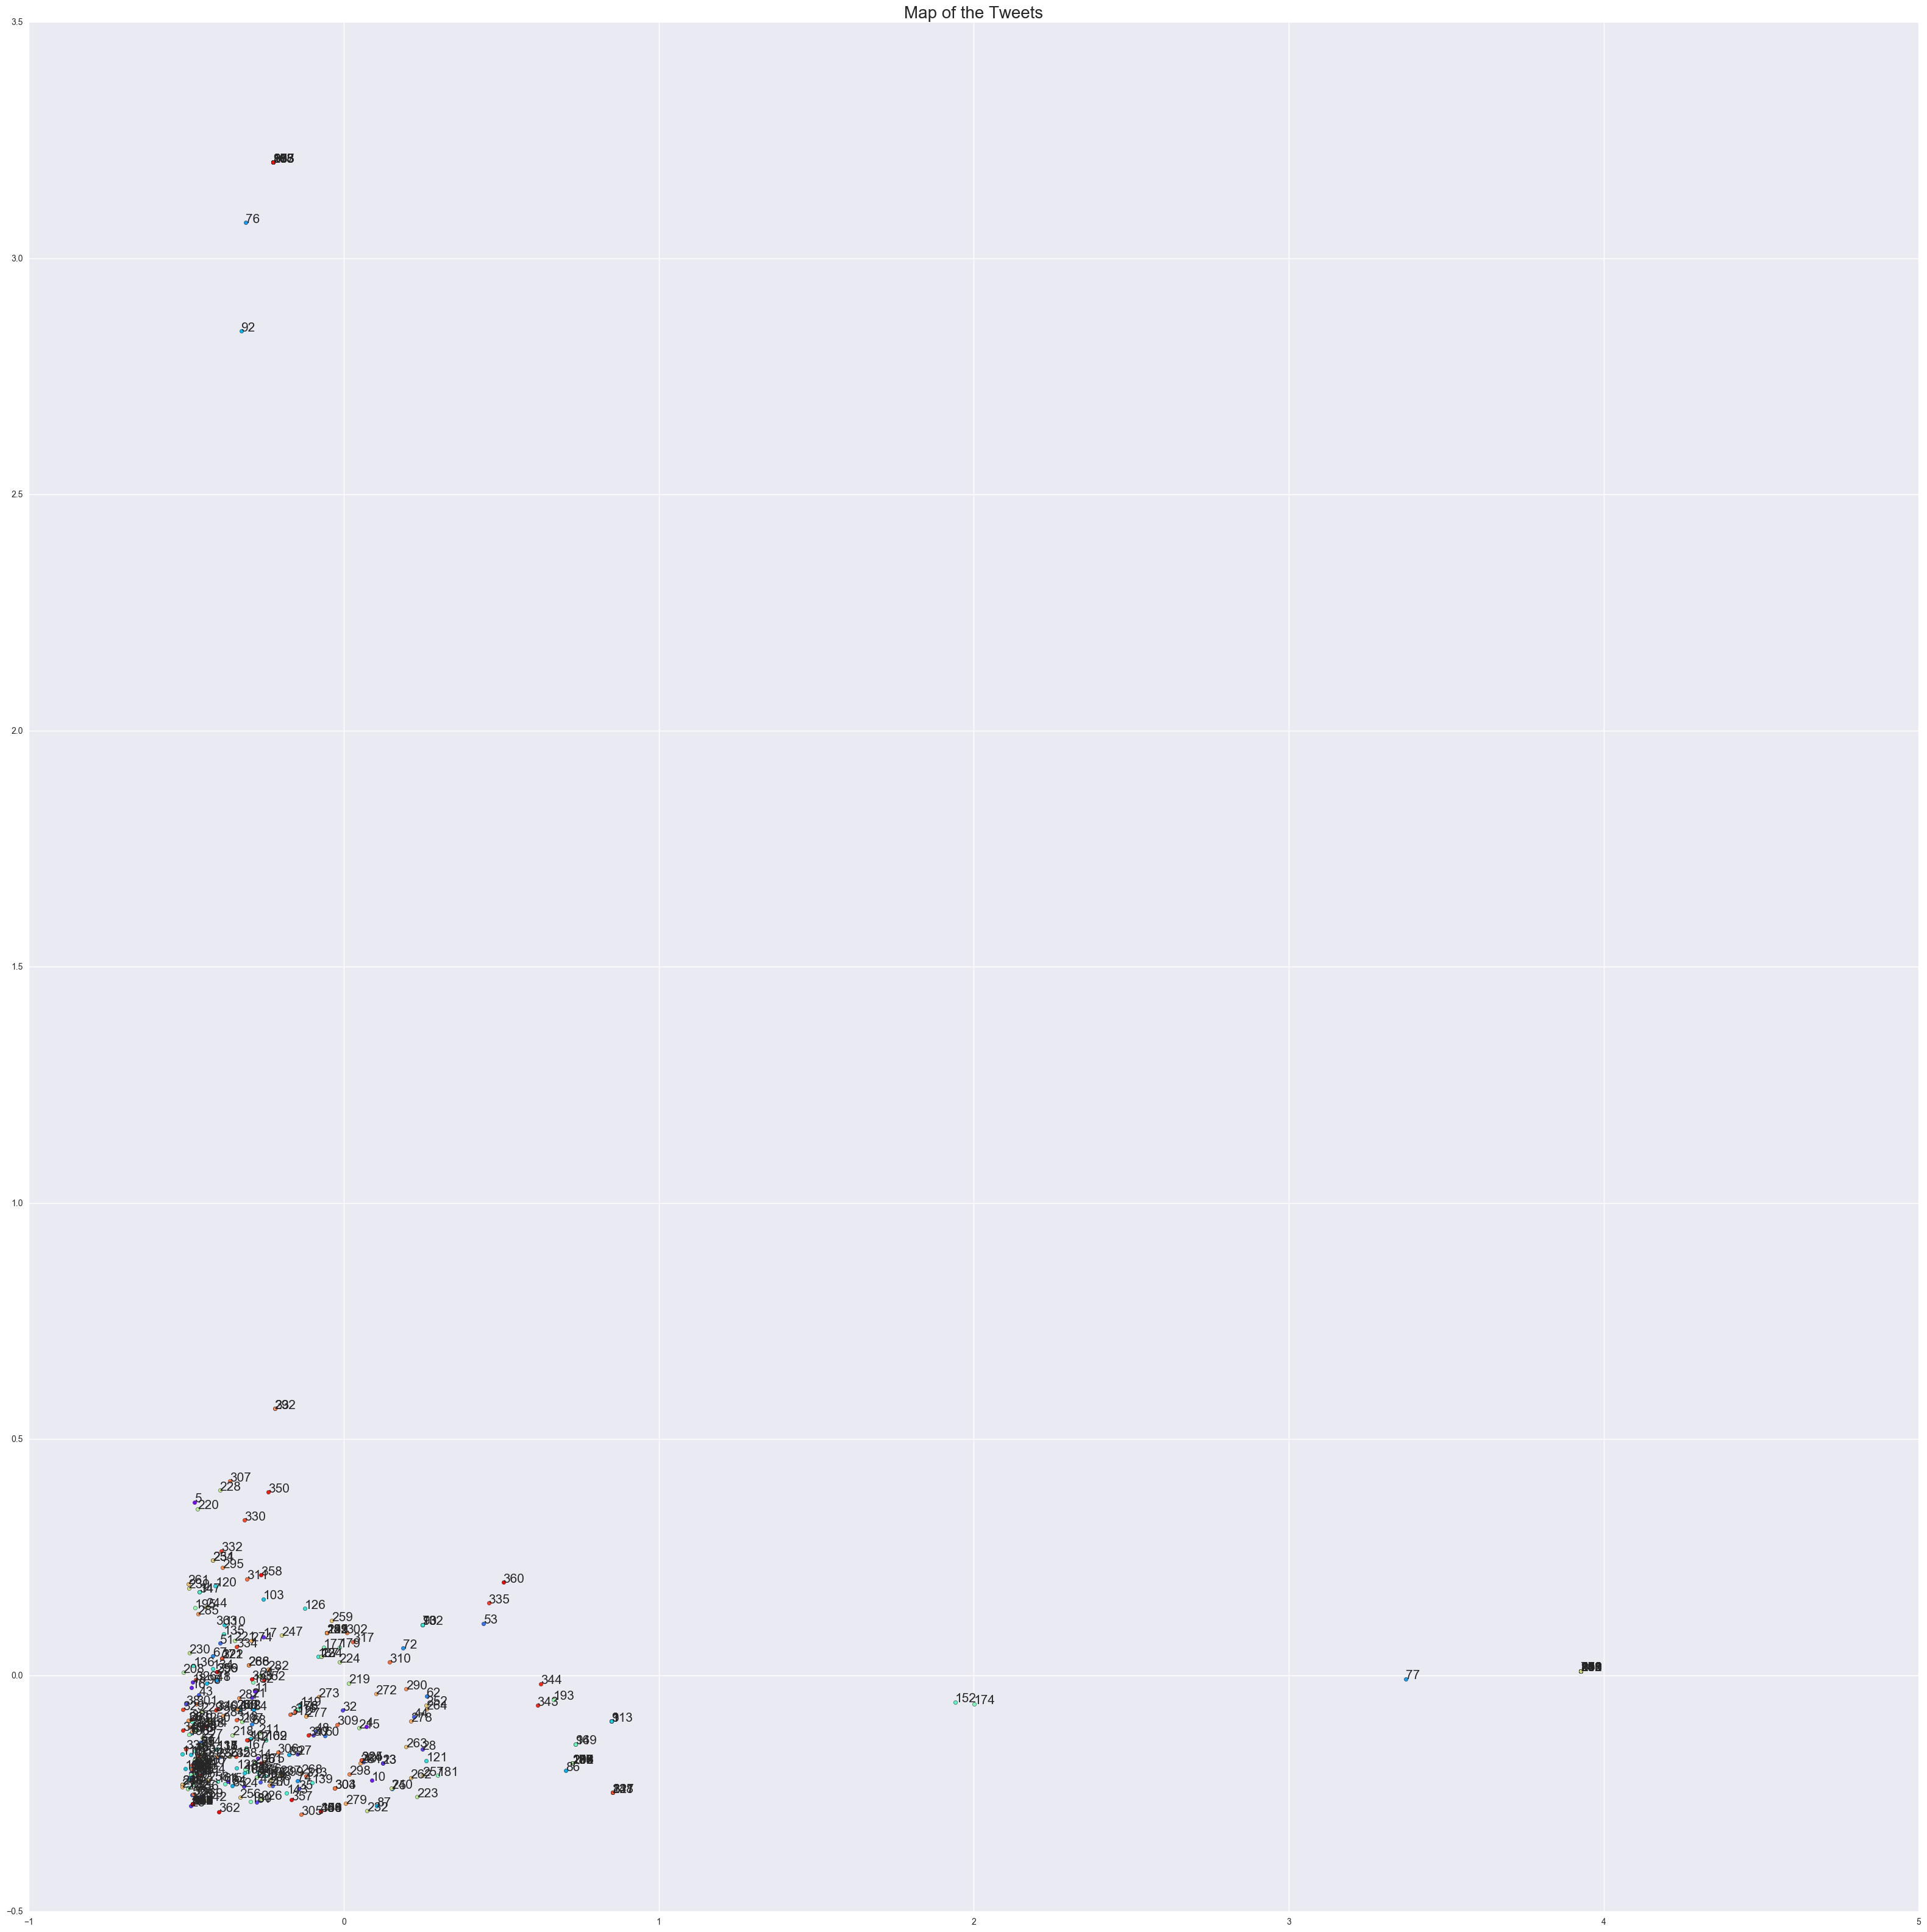

In [69]:
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111)
colors = cm.rainbow(np.linspace(0, 1, len(labels)-1))
for c, i, target_name in zip(colors, [i for i in range(0, len(labels)-1)], labels):
    plt.scatter(data_r[i, 0], data_r[i, 1], c=c, alpha = 1)
    plt.legend()

for i, txt in enumerate(labels):
    plt.annotate(txt, (data_r[i, 0], data_r[i, 1]), fontsize=15)
    
plt.title("Map of the Tweets", fontsize=20)

plt.show()

Finding the Optimum Cluster Number
--

In [70]:
def sorting_through_k(k, data):   
    k_means = KMeans(n_clusters=k)
    k_means.fit(data)
    k_labels_ = k_means.labels_
    centroids_ = k_means.cluster_centers_
    inertia_ = k_means.inertia_
    
    score_ = metrics.silhouette_score(data, k_labels_, metric='euclidean')
    ss_ = inertia_.mean()
    
    return score_, ss_

In [71]:
clusters = [c for c in range(2,15)]
silhouette = [sorting_through_k(clust, data_r)[0] for clust in clusters]
ss_scores = [sorting_through_k(clust, data_r)[1] for clust in clusters]

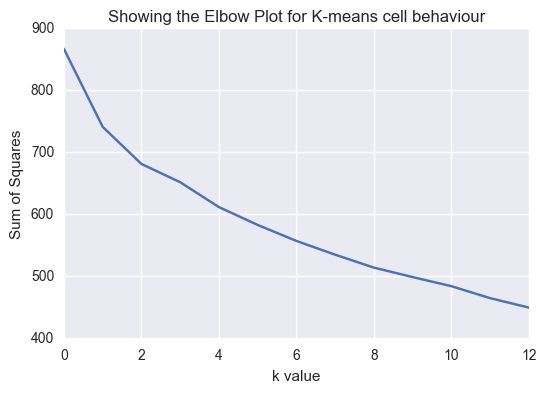

In [72]:
plt.plot(ss_scores)
plt.ylabel("Sum of Squares")
plt.xlabel("k value")
plt.title("Showing the Elbow Plot for K-means cell behaviour")
sns.despine()

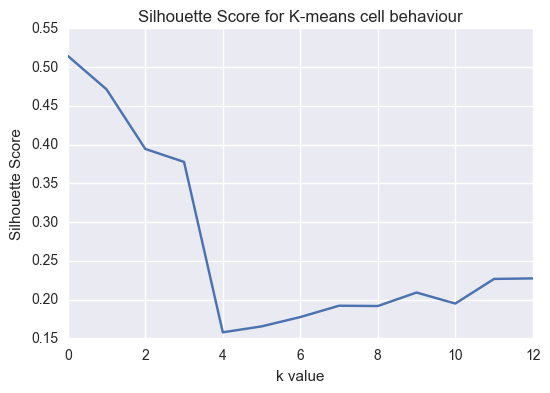

In [73]:
plt.plot(silhouette)
plt.ylabel("Silhouette Score")
plt.xlabel("k value")
plt.title("Silhouette Score for K-means cell behaviour")
sns.despine()

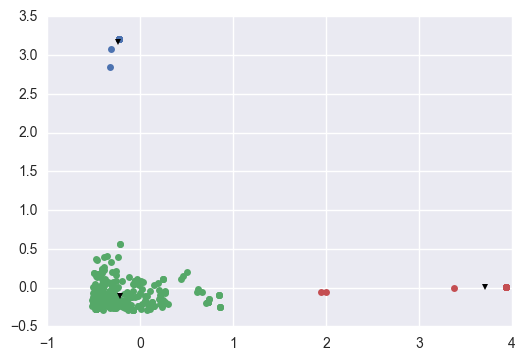

In [74]:
centroids,_ = kmeans(data_r,3)
i_,_ = vq(data_r,centroids)
centroids,_ = kmeans(data_r,3)
plot(data_r[i_==0,0],data_r[i_==0,1],'o',
     data_r[i_==1,0],data_r[i_==1,1], 'o',
     data_r[i_==2,0],data_r[i_==2,1],'o',markersize=5)
plot(centroids[:,0], centroids[:,1],'kv',markersize=5)
show()

Premlimary Results Shown by this Shoddy Graph
---
As you can very clearly see from this graph, I have a slight issue with how my early analysis has classfied the tweets. It's split the group into three very distinct groups, which means that when finding the ideal k value, 3 was given straight away. But honestly, this still doesn't tell me much more than I already knew. 
More work needs to be done.

In [83]:
k_labels = [i_[m] for m in range(len(i_))]
tweet_df['K_Means_Labels'] = k_labels
tweet_df.sort_values(by='K_Means_Labels').head()

,Tweets,K_Means_Labels
95,rt @timothysykes: here's your #dailymotivation...,0
337,rt @timothysykes: here's your #dailymotivation...,0
118,rt @timothysykes: here's your #dailymotivation...,0
163,rt @timothysykes: here's your #dailymotivation...,0
165,rt @timothysykes: here's your #dailymotivation...,0


Naive Bayes to be able to Classify Incoming Tweets
---
Using NB on the assigned labels in the training set, I then tried to produce a model that would be able to predict what cluster the incoming tweet should fall into. 
Hopefully this'll mean I won't have to do any human sorting of the tweets, I'll just be feed tweets that have already been sorted by the model. 
Again, this is going to need a lot of work. 

In [76]:
vect = CountVectorizer(stop_words='english', ngram_range=(1,3))
X = tweet_df.Tweets
y = tweet_df.K_Means_Labels
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [77]:
nb = MultinomialNB()
X_trans = vect.fit_transform(X)
nb.fit(X_trans, y)
nb.score(X_trans, y)

0.98076923076923073

In [78]:
X_train_trans = vect.fit_transform(X_train)
X_test_trans = vect.transform(X_test)

In [79]:
nb.fit(X_train_trans, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [80]:
y_test_k_pred = nb.predict(X_test_trans)

In [81]:
print metrics.accuracy_score(y_test, y_test_k_pred)

1.0


Results (if you can call it that)
---
This will need a lot of work. I think my next step will be to do some more processing on the tweets themselves e.g. eliminate '@whoever' and focus on only the core words. Because the output of my model says that I have a 100% prediction record ... but I suspect that's because all my test values are assigned to a single cluster, meaning the model has a choice of one answer. Who wouldn't get 100% in a multiple choice test with one answer?!
I shall have to do more processing of the tweets to be able to take this model further. 